In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ml_metrics import quadratic_weighted_kappa
import xgboost as xgb
import datetime as dt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import functools
from sklearn.metrics import confusion_matrix


In [2]:
data = pd.read_csv('data_imputed.csv')
pd.options.display.max_columns = None
print(data['Response'].dtype)
data.head()

float64


,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Ht,Id,Ins_Age,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Medical_History_1,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_2,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_3,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_4,Medical_History_40,Medical_History_41,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_Keyword_1,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_2,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_3,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_4,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Wt,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,C1,C2,C3,C4,D1,D2,D3,D4,E1,Response,train?
0,0.323008,0.028,12,1,0,3,-1.0000,2,-1.000000,0.598039,-1.000000,0.526786,0.581818,2,0.641791,1,1,3,1,0.000667,1,1,2,1,2,6,3,1,2,1,4,-1,3,2,3,3,240,3,3,1,1,112,2,1,2,3,-1,1,3,3,1,3,2,2,3,-1,1,3,1,2,2,1,3,1,3,3,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,0.076923,2,1,1,0.148536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,True
1,0.272288,0.000,1,3,0,2,0.0018,2,0.188406,-1.000000,0.084507,-1.000000,0.600000,5,0.059701,2,1,3,1,0.000133,1,3,2,1,2,6,3,1,2,1,5,-1,3,2,3,3,0,1,3,1,1,412,2,1,2,3,-1,1,3,3,1,3,2,2,3,-1,3,1,1,2,2,1,3,1,3,1,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,0.131799,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,True
2,0.428780,0.030,9,1,0,2,0.0300,3,0.304348,-1.000000,0.225352,-1.000000,0.745455,6,0.029851,2,1,1,3,-1.000000,3,2,3,1,2,8,3,1,1,1,10,-1,3,2,3,3,-1,1,3,1,1,3,2,1,2,3,-1,2,2,3,1,3,2,2,3,-1,3,3,1,3,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,0.288703,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,True
3,0.352438,0.042,9,1,0,3,0.2000,3,0.420290,-1.000000,0.352113,-1.000000,0.672727,7,0.164179,2,1,1,3,-1.000000,3,2,3,2,2,8,3,1,2,1,0,-1,3,2,3,3,-1,1,3,1,1,350,2,2,2,3,-1,1,3,3,1,3,2,2,3,-1,3,3,1,2,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,0.487179,2,3,1,0.205021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,True
4,0.424046,0.027,9,1,0,2,0.0500,2,0.463768,-1.000000,0.408451,-1.000000,0.654545,8,0.417910,2,1,1,3,-1.000000,3,2,3,1,2,6,3,1,2,1,-1,-1,3,2,3,3,-1,1,3,1,1,

In [3]:
train_features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
train_labels = data[data['train?'] == True]['Response'] -1 

print(train_labels.value_counts().sort_index())
print()
print(len(train_labels.value_counts()))
print(len(train_features))
print(len(train_labels))
train_features.head()



0     6207
1     6552
2     1013
3     1428
4     5432
5    11233
6     8027
7    19489
Name: Response, dtype: int64

8
59381
59381


,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Ht,Ins_Age,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Medical_History_1,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_2,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_3,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_4,Medical_History_40,Medical_History_41,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_Keyword_1,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_2,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_3,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_4,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Wt,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,C1,C2,C3,C4,D1,D2,D3,D4,E1
0,0.323008,0.028,12,1,0,3,-1.0000,2,-1.000000,0.598039,-1.000000,0.526786,0.581818,0.641791,1,1,3,1,0.000667,1,1,2,1,2,6,3,1,2,1,4,-1,3,2,3,3,240,3,3,1,1,112,2,1,2,3,-1,1,3,3,1,3,2,2,3,-1,1,3,1,2,2,1,3,1,3,3,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,0.076923,2,1,1,0.148536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.272288,0.000,1,3,0,2,0.0018,2,0.188406,-1.000000,0.084507,-1.000000,0.600000,0.059701,2,1,3,1,0.000133,1,3,2,1,2,6,3,1,2,1,5,-1,3,2,3,3,0,1,3,1,1,412,2,1,2,3,-1,1,3,3,1,3,2,2,3,-1,3,1,1,2,2,1,3,1,3,1,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,0.131799,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.428780,0.030,9,1,0,2,0.0300,3,0.304348,-1.000000,0.225352,-1.000000,0.745455,0.029851,2,1,1,3,-1.000000,3,2,3,1,2,8,3,1,1,1,10,-1,3,2,3,3,-1,1,3,1,1,3,2,1,2,3,-1,2,2,3,1,3,2,2,3,-1,3,3,1,3,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,0.288703,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.352438,0.042,9,1,0,3,0.2000,3,0.420290,-1.000000,0.352113,-1.000000,0.672727,0.164179,2,1,1,3,-1.000000,3,2,3,2,2,8,3,1,2,1,0,-1,3,2,3,3,-1,1,3,1,1,350,2,2,2,3,-1,1,3,3,1,3,2,2,3,-1,3,3,1,2,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,0.487179,2,3,1,0.205021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.424046,0.027,9,1,0,2,0.0500,2,0.463768,-1.000000,0.408451,-1.000000,0.654545,0.417910,2,1,1,3,-1.000000,3,2,3,1,2,6,3,1,2,1,-1,-1,3,2,3,3,-1,1,3,1,1,162,2,1,2,3,-1,2,2,3,1,3,2,2,3,-1,3,3,1,3,2,1,3,2,3,1,1,3

# Define functions to train a model with xgboost


In [72]:
def xg_eval_pred(features, labels, test_features, test_labels, param, num_round):
    
    features = np.asarray(features)
    labels = np.asarray(labels)
    
    test_features = np.asarray(test_features)
    test_labels = np.asarray(test_labels)    
    

    xg_train = xgb.DMatrix(features, labels)
    xg_test = xgb.DMatrix(test_features, test_labels)

    watchlist = [(xg_train,'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round)
    
    train_prediction = bst.predict(xg_train)
    test_prediction = bst.predict(xg_test)
    
    return (bst,
            quadratic_weighted_kappa(labels,np.array(train_prediction)),
            quadratic_weighted_kappa(test_labels,np.array(test_prediction)), test_labels, test_prediction)


def make_plot_eval(y, yhat, text, kappa_text):
    fig,ax = plt.subplots(1,2, figsize=(9., 4.))
    
    y = pd.Series(y)
    yhat = pd.Series(yhat)

    yhist = y.value_counts()
    yhathist = yhat.value_counts()

    ax[0].scatter(yhist.index, yhist.values, s=40, c='blue', alpha=0.5, label='response')
    ax[0].scatter(yhathist.index-0.1, yhathist.values, s=40, c='green', alpha=0.5, label='prediction')
    
    ax[0].legend(loc='upper left', prop={'size':10})
    ax[0].set_xlabel('classification')
    ax[0].set_ylabel('frequency')
    
    
    
    ax[0].text(0.99, 1.01, text, fontsize=9,
            ha='right', va='bottom', transform=ax[0].transAxes)
    
    cm = confusion_matrix(y, yhat)
    print(cm)
    
    im = ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_xlabel('true label')
    ax[1].set_ylabel('predicted label')    
    plt.colorbar(im)
    
    ax[1].text(0.99, 1.01, kappa_text, fontsize=12,
            ha='right', va='bottom', transform=ax[1].transAxes)

    fname = 'plots/classification_' + text.replace(':', '').replace(', ', '_').replace(' ','') + '.png'
    fig.savefig(fname, dpi=150)


def learning(data, eval_function, xgbparam, num_round, nsamples=[10000, 25000]):

    features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
    labels = data[data['train?'] == True]['Response'].astype('int') -1 
    
    text = "{} eta:{:0.2f}, max_depth:{:d},\nmin_child_weight:{:0.2f}, num_round:{:02d}".format(
        xgbparam['objective'],
        xgbparam['eta'], xgbparam['max_depth'], xgbparam['min_child_weight'], num_round)

    # Xtest, ytest will be saved for evaluating over a constant sized set:
    Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.70, random_state=17)


    # The number of samples taken out of X for training will be varied
    nsamples.append(len(Xtrain))

    results = []
    for n in nsamples:
        print("Working on n = {:05d}  at {:%H:%M:%S}".format(n, dt.datetime.now()))
        if n < len(Xtrain):
            Xsample, _, ysample, _ = train_test_split(Xtrain, ytrain, test_size=n, random_state=42)
        else:
            Xsample, ysample = Xtrain, ytrain
            
        model, train_qwk, test_qwk, y, yhat = eval_function(Xsample, ysample, Xtest, ytest, xgbparam, num_round)
        results.append([n, train_qwk, test_qwk])
        
        print("num categories = {:d}".format(len(np.unique(yhat))))
        
        print("train_qwk: {:0.4f}, test_qwk: {:0.4f}".format(train_qwk, test_qwk))
                          
        if n == len(Xtrain):
            kappa_text = '$\kappa_{{q,\mathrm{{train}}}} = {:0.4f}$, '.format(train_qwk) + \
            '$\kappa_{{q,\mathrm{{test}}}} = {:0.4f}$'.format(test_qwk)
            make_plot_eval(y, yhat, text, kappa_text)


        
    
    df = pd.DataFrame(results, columns=['num_samples', 'train_qwk', 'test_qwk'])
    
    if len(nsamples) > 1:
        make_plot_learning(df, text, num_round)
    
    return model, df


def make_plot_learning(df, text, num_round):
    fig,ax = plt.subplots(1,1)

    ax.scatter(df['num_samples'], df['train_qwk'], s=40, c='blue', alpha=0.5, label='train set')
    ax.scatter(df['num_samples'], df['test_qwk'], s=40, c='green', alpha=0.5, label='test set')
    
    ax.legend(loc='upper left', prop={'size':10})
    ax.set_xlabel('number of training samples')
    ax.set_ylabel('quadratic weighted kappa')
    

    ax.text(0.99, 1.01, text, fontsize=9,
            ha='right', va='bottom', transform=ax.transAxes)
    
    fname = 'plots/learning_' + text.replace(':', '').replace(', ', '_').replace(' ','') + '.png'
    fig.savefig(fname, dpi=150)


8

----------------------------------------
num boosting rounds =  5
Working on n = 41566  at 13:13:09
num categories = 8
train_qwk: 0.5091, test_qwk: 0.4837
[[ 222  250   43   75  180  360  266  493]
 [  84  433   29   51  239  401  215  483]
 [   8    8  112  119   31   18    7   18]
 [   6    0   13  338    0   19   13   54]
 [  26  136    0    0  902  270   91  192]
 [  60   95    1    7  168 1677  426  864]
 [  23   11    0    0   15  468  934 1008]
 [   6    5    0    4   13  185  189 5451]]


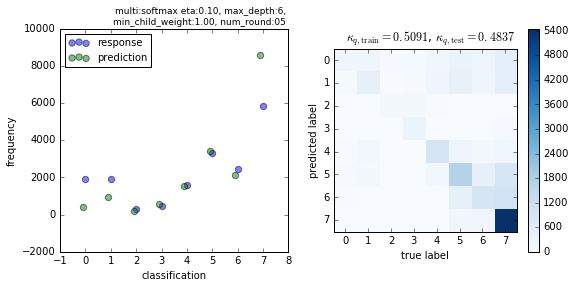

In [62]:
data = pd.read_csv('data_imputed.csv')

# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'multi:softmax'

# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['min_child_weight'] = 1

param['silent'] = 1
param['nthread'] = 1
param['num_class'] = len(pd.Series(data['Response']).value_counts())

print(param['num_class'])

results = []
for num_round in [5]:
    print("\n" + "-"*40)
    print("num boosting rounds = ", num_round)
    results.append(learning(data, xg_eval_pred, param, num_round, nsamples=[]))
    

### Define a function that will use a reg:linear objective (as opposed to the multi:softmax typically used for classification in xgboost

In [63]:
def xg_eval_linear_pred(features, labels, test_features, test_labels, param, num_round, classify_function):
    
    features = np.asarray(features)
    labels = np.asarray(labels)
    
    test_features = np.asarray(test_features)
    test_labels = np.asarray(test_labels)
    

    xg_train = xgb.DMatrix(features, labels)
    xg_test = xgb.DMatrix(test_features, test_labels)

    bst = xgb.train(param, xg_train, num_round)
    
    train_prediction = classify_function(bst.predict(xg_train))
    test_prediction = classify_function(bst.predict(xg_test))
    
    return (bst,
            quadratic_weighted_kappa(labels,np.array(train_prediction)),
            quadratic_weighted_kappa(test_labels,np.array(test_prediction)), test_labels, test_prediction)


----------------------------------------
num boosting rounds =  5
Working on n = 41566  at 13:13:48
num categories = 4
train_qwk: 0.1472, test_qwk: 0.1426
[[  40  497  948  404    0    0    0    0]
 [  10  610  946  369    0    0    0    0]
 [   1  195  108   17    0    0    0    0]
 [   2  256  138   47    0    0    0    0]
 [   0  255 1190  172    0    0    0    0]
 [   0  154 2449  695    0    0    0    0]
 [   0   18 1401 1040    0    0    0    0]
 [   0    3 1194 4656    0    0    0    0]]

----------------------------------------
num boosting rounds =  25
Working on n = 41566  at 13:13:50
num categories = 7
train_qwk: 0.5446, test_qwk: 0.5122
[[  25  215  338  425  436  345  105    0]
 [   3  227  372  452  457  325   99    0]
 [   1   20  169   72   37   13    9    0]
 [   0    6  136  167   68   39   27    0]
 [   0   20  187  665  518  180   47    0]
 [   0   12  111  494 1459 1011  211    0]
 [   0    1   14  151  847 1030  416    0]
 [   0    0    0   25  358 2319 3151    0

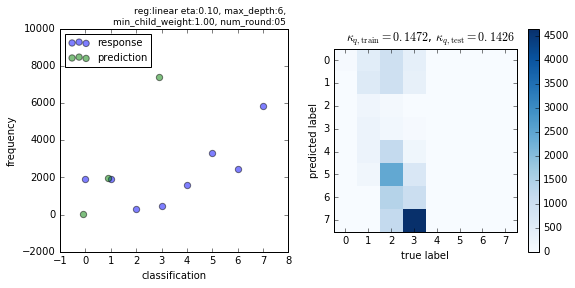

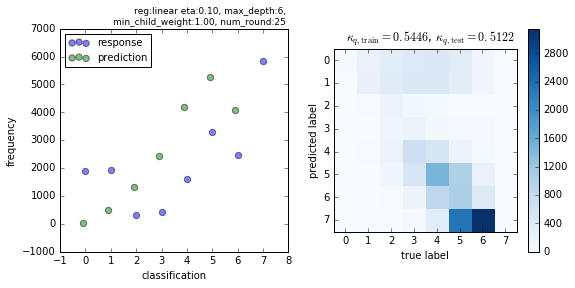

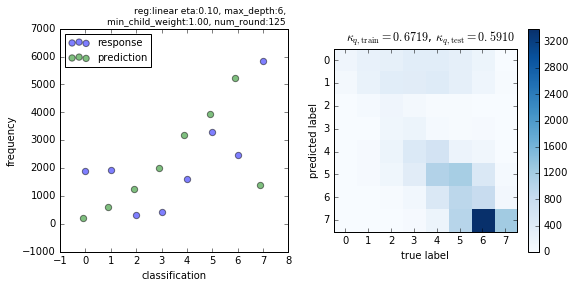

In [64]:
data = pd.read_csv('data_imputed.csv')

# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['min_child_weight'] = 1

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
for num_round in [5, 25, 125]:
    print("\n" + "-"*40)
    print("num boosting rounds = ", num_round)
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

The reg:linear objective is better for this problem, since the evaluation metric is the quadratic weighted kappa, which takes into account the relative distance between categories.   From now on we will stick to the reg:linear objective.

### Tuning:

If model has high variance (large diff in test-train at full dataset):

* decrease eta
* decrease max depth
* increase min child weight

If model has high bias (small diff in test-train at full dataset):

* increase eta
* increase max depth
* decrease min child weight


# Try to tune parameters by hand

Increase min child weight by two orders of magnitude:


----------------------------------------
min_child_weight = 1
Working on n = 41566  at 13:20:48
num categories = 8
train_qwk: 0.6839, test_qwk: 0.5946
[[ 141  254  281  351  361  305  181   15]
 [  66  236  369  386  412  292  156   18]
 [  11   48  139   76   20   15   11    1]
 [   3   11  136  183   40   25   38    7]
 [   6   33  184  473  611  185  119    6]
 [   4   32  130  388 1039 1169  487   49]
 [   0    5   24  100  473  942  815  100]
 [   1    0    5   39  179  999 3291 1339]]

----------------------------------------
min_child_weight = 10
Working on n = 41566  at 13:21:12
num categories = 8
train_qwk: 0.6777, test_qwk: 0.5958
[[ 141  243  306  343  350  305  186   15]
 [  69  229  375  389  420  279  156   18]
 [  10   47  141   69   27   15   11    1]
 [   3   13  129  191   37   26   36    8]
 [   5   34  173  459  632  191  118    5]
 [   5   29  133  389 1018 1187  495   42]
 [   0    5   24   93  476  951  817   93]
 [   0    2    3   31  199 1000 3251 1367]]

----

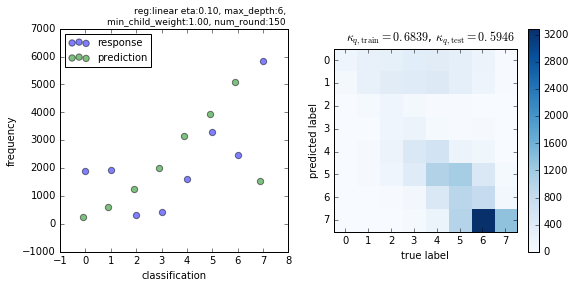

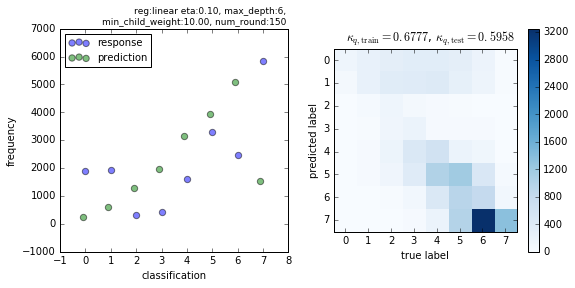

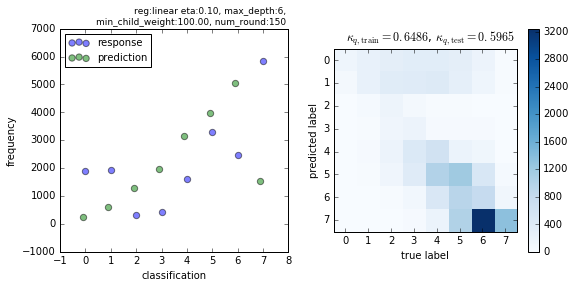

In [65]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['min_child_weight'] = 1

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

for val in [1, 10, 100]:
    param['min_child_weight'] = val
    print("\n" + "-"*40)
    print("min_child_weight = {}".format(val))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

Variance is getting better, so try even larger values of min_child_weight


----------------------------------------
min_child_weight = 400
Working on n = 41566  at 13:23:50
num categories = 8
train_qwk: 0.6181, test_qwk: 0.5865
[[ 118  247  303  357  360  303  183   18]
 [  61  238  373  376  402  297  166   22]
 [   7   44  132   87   25   15    9    2]
 [   3   19  163  127   62   24   36    9]
 [   4   33  205  474  577  201  117    6]
 [   3   24  135  416 1002 1200  475   43]
 [   0    1   19  105  494  953  792   95]
 [   0    0    2   28  206 1056 3289 1272]]

----------------------------------------
min_child_weight = 1600
Working on n = 41566  at 13:24:14
num categories = 8
train_qwk: 0.5807, test_qwk: 0.5586
[[  48  210  344  366  387  332  180   22]
 [  21  205  423  364  399  325  174   24]
 [   4   68  146   59   21   14    7    2]
 [   0   19  188  147   20   26   38    5]
 [   0   38  253  470  496  239  118    3]
 [   0   15  133  435 1078 1162  426   49]
 [   0    1    8  115  527  988  726   94]
 [   0    0    1   31  252 1242 3083 1244]]


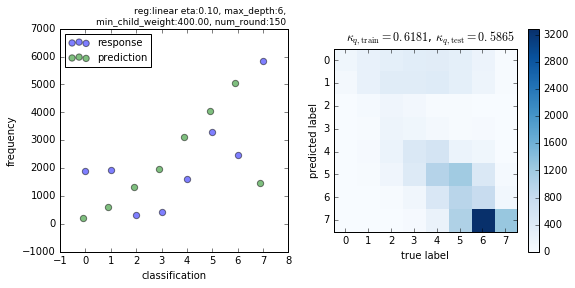

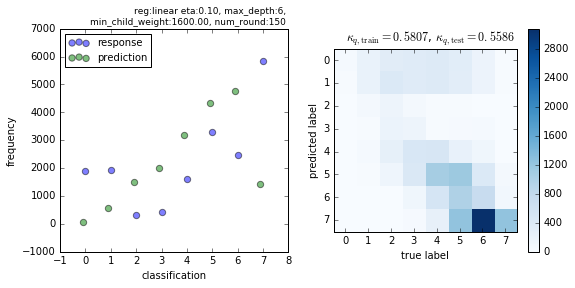

In [66]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['min_child_weight'] = 1

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

for val in [400, 1600]:
    param['min_child_weight'] = val
    print("\n" + "-"*40)
    print("min_child_weight = {}".format(val))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

In going from 100 to 400 for min_child weight, the model started loosing some predictive power.  Will fill in the blanks around that neighborhood:


----------------------------------------
min_child_weight = 50
Working on n = 41566  at 13:26:13
num categories = 8
train_qwk: 0.6599, test_qwk: 0.5949
[[ 143  244  287  368  331  313  186   17]
 [  67  233  369  388  428  275  155   20]
 [  11   46  147   68   22   14   11    2]
 [   3   10  135  189   36   27   35    8]
 [   4   37  178  476  605  201  110    6]
 [   5   27  131  390 1012 1194  490   49]
 [   0    6   20   89  481  951  803  109]
 [   0    0    7   32  201  983 3290 1340]]

----------------------------------------
min_child_weight = 200
Working on n = 41566  at 13:26:38
num categories = 8
train_qwk: 0.6360, test_qwk: 0.5945
[[ 138  244  293  352  353  305  187   17]
 [  63  255  348  404  402  290  152   21]
 [   9   55  141   67   22   15   10    2]
 [   2   16  139  173   44   26   34    9]
 [   3   35  185  476  616  187  110    5]
 [   4   26  130  392 1018 1172  507   49]
 [   0    1   16  111  460  963  806  102]
 [   0    0    3   35  201 1023 3237 1354]]


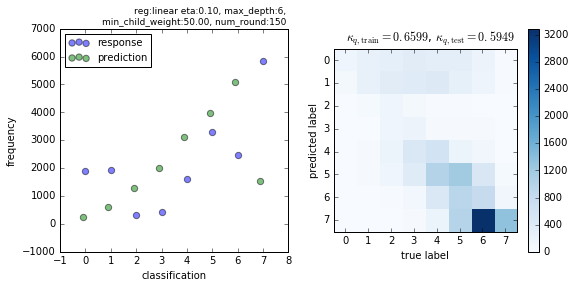

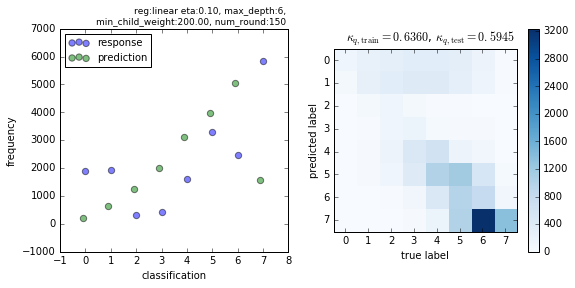

In [67]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['min_child_weight'] = 1

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

for val in [50, 200]:
    param['min_child_weight'] = val
    print("\n" + "-"*40)
    print("min_child_weight = {}".format(val))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

The value of min_child_weight that maximizes kappa for the test set is 100.   Will now experiment with max_depth


----------------------------------------
max_depth = 4
Working on n = 41566  at 13:30:28
num categories = 8
train_qwk: 0.6104, test_qwk: 0.5813
[[ 147  197  299  360  375  313  189    9]
 [  69  208  346  391  447  304  158   12]
 [  11   46  140   63   33   16   10    2]
 [   2   15  122  163   71   27   36    7]
 [   3   33  163  464  643  194  113    4]
 [   5   25  122  374 1008 1271  461   32]
 [   0    2   14   83  506 1004  786   64]
 [   0    0    2   24  198 1093 3528 1008]]

----------------------------------------
max_depth = 6
Working on n = 41566  at 13:30:46
num categories = 8
train_qwk: 0.6486, test_qwk: 0.5965
[[ 148  232  306  349  351  305  184   14]
 [  67  237  369  387  417  287  152   19]
 [  10   47  153   62   22   15   10    2]
 [   1   15  137  187   33   27   35    8]
 [   4   35  180  455  629  193  115    6]
 [   5   25  135  389 1009 1197  495   43]
 [   0    5   17  101  484  939  807  106]
 [   0    0    4   31  202 1015 3245 1356]]

-------------------

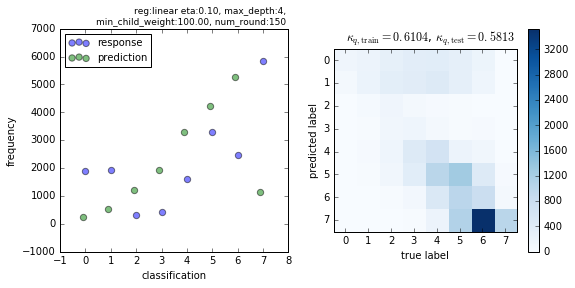

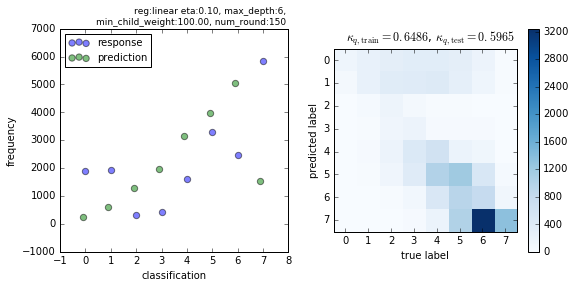

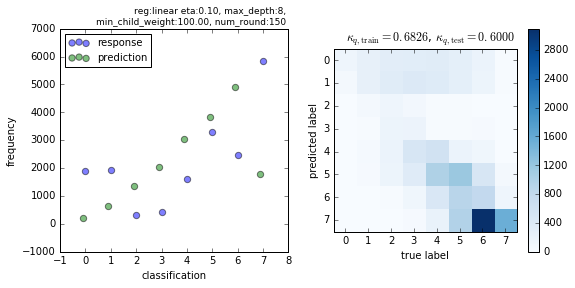

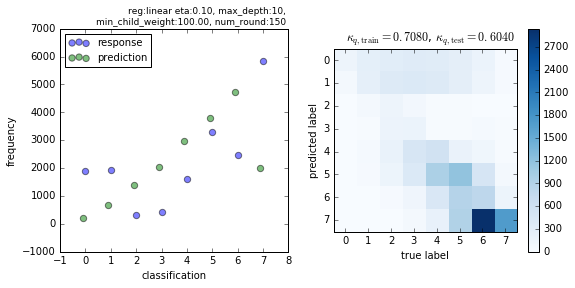

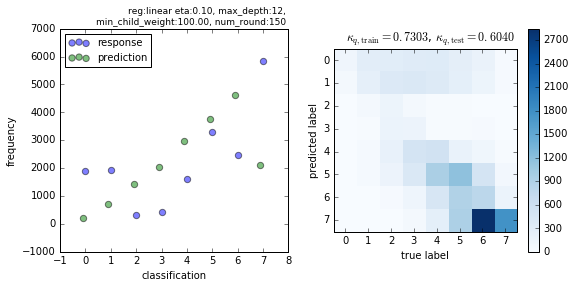

In [68]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

# scale weight of positive examples
param['eta'] = 0.1
param['min_child_weight'] = 100

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

for val in [4, 6, 8, 10, 12]:
    name = 'max_depth'
    param[name] = val
    print("\n" + "-"*40)
    print("{} = {}".format(name, val))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

At a max_depth of 10,  I will now vary eta: 


----------------------------------------
eta = 0.05
Working on n = 41566  at 13:35:21
num categories = 8
train_qwk: 0.6648, test_qwk: 0.5951
[[  89  272  325  358  352  296  177   20]
 [  41  247  377  405  410  275  160   20]
 [   3   45  162   67   18   15    9    2]
 [   1    9  173  178   13   21   39    9]
 [   0   35  194  498  595  174  113    8]
 [   1   23  147  399  990 1219  472   47]
 [   0    0   27  107  488  929  802  106]
 [   0    0    4   39  204  961 3226 1419]]

----------------------------------------
eta = 0.2
Working on n = 41566  at 13:36:04
num categories = 8
train_qwk: 0.7570, test_qwk: 0.6017
[[ 160  256  329  320  342  272  180   30]
 [  84  248  378  383  376  280  153   33]
 [  11   57  144   60   24   15    8    2]
 [   4   28  161  164   19   22   33   12]
 [   5   59  189  490  540  216  100   18]
 [   3   43  170  414  924 1137  523   84]
 [   0    6   32  139  429  820  835  198]
 [   0    2    9   55  282  904 2730 1871]]

--------------------------

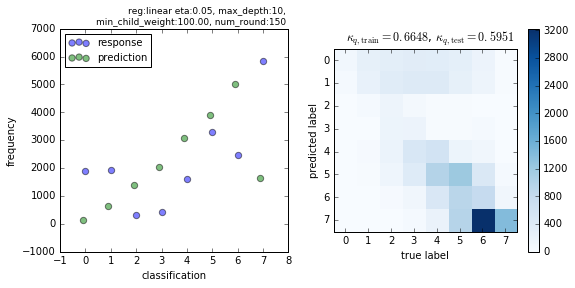

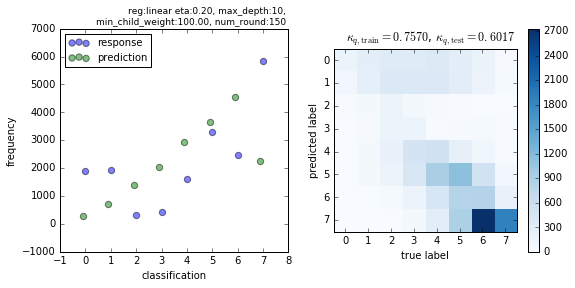

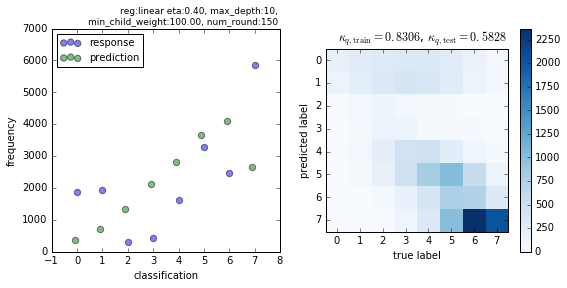

In [69]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['max_depth'] = 10
param['min_child_weight'] = 100

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

for val in [0.05, 0.2, 0.4]:
    name = 'eta'
    param[name] = val
    print("\n" + "-"*40)
    print("{} = {}".format(name, val))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

Let's keep a small eta and decrease the min child weight:

Working on n = 41566  at 13:40:34
num categories = 8
train_qwk: 0.6937, test_qwk: 0.5952
[[  94  282  317  348  353  295  181   19]
 [  25  281  357  409  406  278  160   19]
 [   4   43  153   74   20   14   11    2]
 [   2   14  154  187   17   24   35   10]
 [   0   40  195  491  589  183  112    7]
 [   2   29  136  388  995 1216  483   49]
 [   0    3   26  101  469  927  819  114]
 [   0    0    5   47  210  949 3216 1426]]


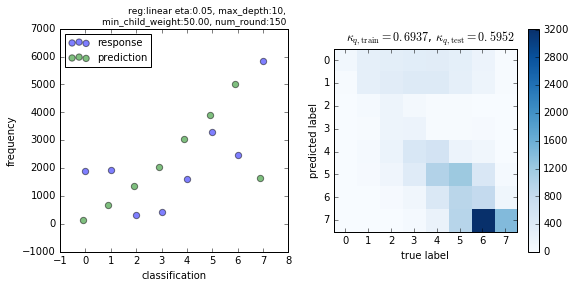

In [70]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['eta'] = 0.05
param['max_depth'] = 10
param['min_child_weight'] = 50

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
num_round = 150

results.append(learning(data, evalfun, param, num_round, nsamples=[]))

I want to increase the number of rounds, but for that I need to set the parameters to have a model with less variance:


----------------------------------------
num_round = 150
Working on n = 41566  at 13:45:41
num categories = 8
train_qwk: 0.6251, test_qwk: 0.5873
[[  92  240  342  358  352  306  188   11]
 [  31  241  387  398  414  283  163   18]
 [   3   44  153   74   20   14   11    2]
 [   1   10  151  183   29   27   34    8]
 [   0   25  196  501  588  190  114    3]
 [   1   18  151  387  997 1223  484   37]
 [   0    0   17  101  505  928  831   77]
 [   0    0    0   36  205 1018 3439 1155]]

----------------------------------------
num_round = 250
Working on n = 41566  at 13:46:13
num categories = 8
train_qwk: 0.6501, test_qwk: 0.5979
[[ 120  246  332  341  347  302  186   15]
 [  51  249  385  403  395  272  159   21]
 [   5   52  150   69   22   11   10    2]
 [   2   18  153  185   16   23   37    9]
 [   1   31  196  503  573  193  114    6]
 [   4   21  159  394  956 1221  492   51]
 [   0    0   19  110  479  913  830  108]
 [   0    0    2   39  212  987 3170 1443]]

---------------

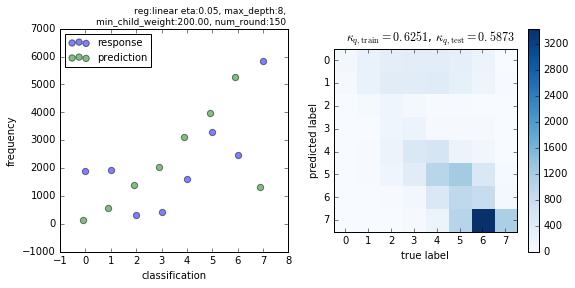

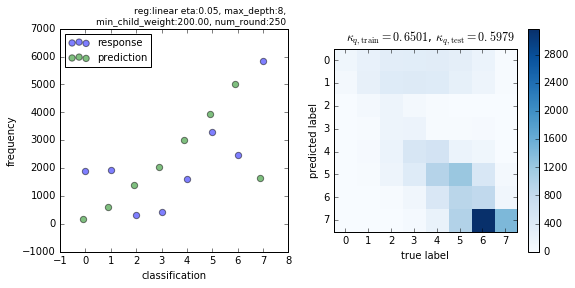

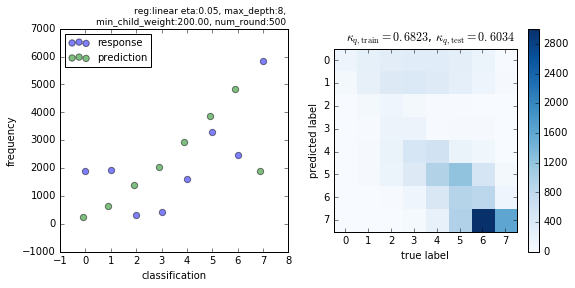

In [71]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['eta'] = 0.05
param['max_depth'] = 8
param['min_child_weight'] = 200

param['silent'] = 1
param['nthread'] = 1


def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))

evalfun = functools.partial(xg_eval_linear_pred, classify_function=classify)

results = []
for num_round in [150, 250, 500]:
    print("\n" + "-"*40)
    print("{} = {}".format("num_round", num_round))
    results.append(learning(data, evalfun, param, num_round, nsamples=[]))

## Conclusion of this step: 

A model with eta=0.05, max_depth=8, min_child_weight=200 and num_round=150 provides a good bias-variance balance and is fast enough that I can go ahead and start trying to do other explorations. 

The next thing I will explore is the optimization of the cutoff points that are used to classify the continuous output of this model into categories.  

## Submission

In [81]:
data = pd.read_csv('data_imputed.csv')

features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?'] == True]['Response'].astype('int') -1 
submission_features = data[data['train?'] == False].drop(['train?', 'Id', 'Response'], axis=1)


# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['eta'] = 0.05
param['max_depth'] = 8
param['min_child_weight'] = 200

param['silent'] = 1
param['nthread'] = 1

def classify(score):
    return np.rint(np.clip(score, -0.49, 7.49))


num_round = 150
xg_train = xgb.DMatrix(features, labels)
print("\n" + "-"*40)
print("{} = {}".format("num_round", num_round))
model = xgb.train(param, xg_train, num_round)


xg_submission = xgb.DMatrix(submission_features)
submission_prediction = model.predict(xg_submission)
submission = classify(submission_prediction)


----------------------------------------
num_round = 150


In [84]:
submission_ids = data[data['train?'] == False]['Id']

submission_df = pd.DataFrame({"Id": submission_ids, "Response": submission.astype('int') + 1})
submission_df = submission_df.set_index('Id')
submission_df.to_csv('step02_submission.csv')


In [86]:
submission_df.describe()

,Response
count,19765.000000
mean,5.619833
std,1.583783
min,1.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,8.000000
